In [2]:
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
IMG_SIZE = (128, 128)

MOUSE_DATA = {
    "mouselog_aidan.txt": 0,
    "mouselog_akshaj.txt": 0,
    "mouselog_eric.txt": 0,
    "mouselog_srujan.txt": 0,
    "mouselog_tony.txt": 1,
}

In [4]:
train_tensors = []
train_labels = []
val_labels = []
val_tensors = []
test_tensors = []
test_labels = []

for log, label in MOUSE_DATA.items():
    # Load the data
    df = pd.read_csv(
        f"data/{log}",
        delimiter=" ",
        names=["date", "time", "action", "x", "y", "a", "b"],
        comment="M",  # Ignore script starting output
    )

    # Convert the date and time to seconds since the first entry
    df["time"] = pd.to_datetime(df["date"] + " " + df["time"], format="ISO8601")
    df["time"] = (df["time"] - df["time"].min()).dt.total_seconds()

    # Normalize x and y to between 0 and 127
    df["x"] = (df["x"] - df["x"].min()) / (df["x"].max() - df["x"].min()) * (IMG_SIZE[1] - 1)
    df["y"] = (df["y"] - df["y"].min()) / (df["y"].max() - df["y"].min()) * (IMG_SIZE[0] - 1)

    # Normalize scroll speed
    df.loc[df["action"] == "scroll", "speed"] = df[df["action"] == "scroll"]["b"].astype(int)
    df.loc[df["action"] == "scroll", "speed"] -= df[df["action"] == "scroll"]["speed"].min()

    # Convert clicking actions to integers
    df.loc[df["action"] == "click", "click"] = pd.factorize(df[df["action"] == "click"]["a"])[0]
    df.loc[df["action"] == "click", "downward"] = df[df["action"] == "click"]["b"]

    # Drop unnecessary columns and change data types
    df = df.drop(columns=["date", "a", "b"])

    # Create a tensor for each 5 second interval
    val_cutoff = 1250 * 0.6 if label == 0 else 5000 * 0.6
    data_cutoff = 1250 if label == 0 else 5000

    tensor = []
    counter = 0
    time = 0
    lo = 0
    max_time = int(df["time"].max())
    df_length = len(df)
    while time < max_time:
        # Capture 5 second intervals
        start_index = bisect.bisect_left(df["time"], time, lo=lo)
        end_index = bisect.bisect_right(df["time"], time + 5, lo=start_index)
        lo = start_index

        # Skip forward if no data is found
        if start_index == end_index:
            time = np.floor(df["time"].iloc[end_index + 1])
            continue

        # Skip forward if the interval is too small or doesn't include click/scroll data
        if end_index - start_index < 128 or not any(
            df["action"].iloc[start_index : end_index + 1].isin(["click", "scroll"])
        ):
            time = max(time + 1, np.floor(df["time"].iloc[start_index + 1]))
            continue

        window = df.iloc[start_index:end_index + 1]

        # Channel 1: mouse movement
        move_tensor = np.zeros(IMG_SIZE)
        x_values, y_values = window["x"].astype(int), window["y"].astype(int)
        intensity = 55 + np.array(40 * (window["time"] - time), dtype=int)
        move_tensor[y_values, x_values] = intensity

        # Channel 2: scroll velocity
        scroll_tensor = np.zeros(IMG_SIZE)
        scroll_rows = window[window["action"] == "scroll"]
        x_values, y_values = scroll_rows["x"].astype(int), scroll_rows["y"].astype(int)
        intensity = 55 + np.minimum(200, 10 * scroll_rows["speed"])
        scroll_tensor[y_values, x_values] = intensity

        # Channel 3: click location
        click_tensor = np.zeros(IMG_SIZE)
        click_rows = window[window["action"] == "click"]
        x_values, y_values = click_rows["x"].astype(int), click_rows["y"].astype(int)
        intensity = 55 + 24 * click_rows["click"] + 128 * (click_rows["downward"] == "True")
        click_tensor[y_values, x_values] = intensity

        # Combine the three channels
        tensor.append(np.stack([move_tensor, scroll_tensor, click_tensor]))

        # Capture itervals every second
        time += 1

        # Ensure that the data is balanced and no train data is leaked into the val set
        counter += 1
        if counter == val_cutoff:
            time = np.floor(df["time"].iloc[end_index + 1])
        elif counter == data_cutoff:
            break

        # Skip if the end of the data is reached
        if end_index == df_length - 1:
            break

    # Split the data into training, validation, and testing sets
    tensor = torch.tensor(np.array(tensor), dtype=torch.uint8)
    label = torch.tensor([label] * len(tensor), dtype=torch.uint8)

    # Split tensor into training, validation, and testing sets
    train_size = int(len(tensor) * 0.6)
    val_size = int(len(tensor) * 0.2)
    train_tensors.append(tensor[:train_size])
    val_tensors.append(tensor[train_size:train_size + val_size])
    test_tensors.append(tensor[train_size+val_size:])
    train_labels.append(label[:train_size])
    val_labels.append(label[train_size:train_size + val_size])
    test_labels.append(label[train_size:train_size + val_size:])

    print(f"Finished processing {log}")

train_tensors = torch.cat(train_tensors)
train_labels = torch.cat(train_labels)
val_tensors = torch.cat(val_tensors)
val_labels = torch.cat(val_labels)
test_tensors = torch.cat(test_tensors)
test_labels = torch.cat(test_labels)

Finished processing mouselog_aidan.txt
Finished processing mouselog_akshaj.txt
Finished processing mouselog_eric.txt
Finished processing mouselog_srujan.txt
Finished processing mouselog_tony.txt


In [5]:
batch_size = 32

train_dataset = TensorDataset(train_tensors, train_labels)
val_dataset = TensorDataset(val_tensors, val_labels)
test_dataset = TensorDataset(test_tensors, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, is_first=False):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 3, stride=stride, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        # If first block in layer, shortcut is 1x1 convolution
        self.shortcut = nn.Sequential()
        if is_first:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.conv(x)
        residual = self.shortcut(x)
        return F.relu(out + residual)


class ResNet(nn.Module):
    def __init__(self, layers, in_channels=64):
        super(ResNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, in_channels, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        self.layers = nn.ModuleList()
        self.layers.append(self.make_layer(layers[0], in_channels, in_channels, 1))
        for i in range(1, len(layers)):
            channels = in_channels * 2 ** (i - 1)
            self.layers.append(self.make_layer(layers[i], channels, channels * 2, 2))

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels * 2 ** (len(layers) - 1), 2)

    def make_layer(self, num_blocks, in_channels, out_channels, stride):
        layers = nn.ModuleList()
        layers.append(ResidualBlock(in_channels, out_channels, stride, is_first=True))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        for layer in self.layers:
            out = layer(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

Epoch [1/100], Train Loss: 0.30168075637022657, Val Loss: 0.5651853549703956, Val Accuracy: 77.7%
Epoch [2/100], Train Loss: 0.06510709160069625, Val Loss: 0.3633970023484435, Val Accuracy: 85.8%
Epoch [3/100], Train Loss: 0.021308793811127543, Val Loss: 0.427501387146418, Val Accuracy: 85.5%
Epoch [4/100], Train Loss: 0.020669840242558468, Val Loss: 0.4952681164610549, Val Accuracy: 86.3%
Epoch [5/100], Train Loss: 0.010903898616709436, Val Loss: 0.681253505168279, Val Accuracy: 86.35%
Epoch [6/100], Train Loss: 0.013557805062271654, Val Loss: 0.44762883180806967, Val Accuracy: 86.65%
Epoch [7/100], Train Loss: 0.01721506438823417, Val Loss: 0.6089410404084338, Val Accuracy: 88.05%
Epoch [8/100], Train Loss: 0.0055027241338587675, Val Loss: 0.5119596420669914, Val Accuracy: 87.4%
Epoch [9/100], Train Loss: 0.007696223940292839, Val Loss: 0.6690583997317299, Val Accuracy: 87.25%
Epoch [10/100], Train Loss: 0.010968738420885832, Val Loss: 0.5289134802039043, Val Accuracy: 87.8%
Epoch [1

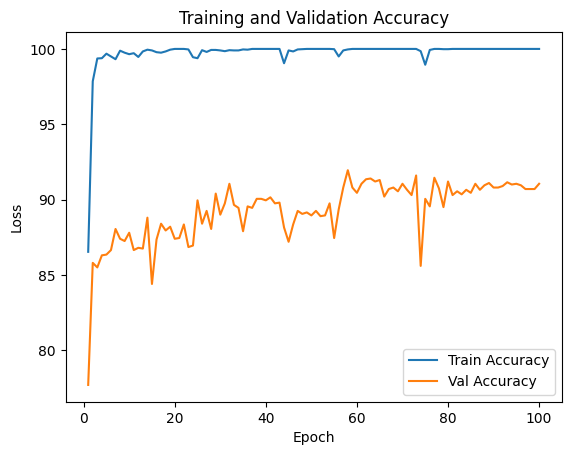

In [10]:
model = ResNet([3, 4, 6, 3]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training the model
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = (correct / total) * 100.0
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_accuracy}%")

# Plotting train and val losses
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

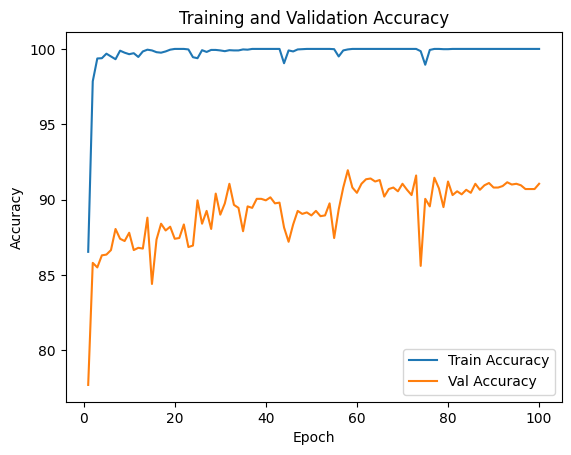

In [11]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [13]:
torch.save(model, "model.pth")

In [8]:
model = ResNet([3, 4, 6, 3]).to(device)
model = torch.load("model.pth")
criterion = nn.CrossEntropyLoss()

In [23]:
for batch_size in [1, 3, 9, 27]:
    true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
    correct, total = 0, 0
    test_batch_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for images, labels in test_batch_loader:
            images, labels = images.to(device), labels.to(device)

            if len(set(labels.tolist())) != 1:
                continue

            outputs = model(images.float())
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            predicted = torch.mode(predicted)[0].item()

            label = labels[0]
            total += 1
            correct += predicted == label

            true_positives += ((predicted == 0) & (label == 0)).sum().item()
            true_negatives += ((predicted == 1) & (label == 1)).sum().item()
            false_positives += ((predicted == 0) & (label == 1)).sum().item()
            false_negatives += ((predicted == 1) & (label == 0)).sum().item()

    print(f"Calculating for batch size {batch_size}")

    test_accuracy = 100 * correct / total
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / (
        true_positives + true_negatives + false_positives + false_negatives
    )

    print(f"Test Accuracy: {test_accuracy:.3f}%")
    print(f"TP/FP, FN/TN: {true_positives}/{false_positives}, {false_negatives}/{true_negatives}")
    print(f"Accuracy, precision, recall, f1-score: {accuracy:.3f}, {precision:.3f}, {recall:.3f}, {f1_score:.3f}")

Calculating for batch size 1
Test Accuracy: 91.300%
TP/FP, FN/TN: 862/36, 138/964
Accuracy, precision, recall, f1-score: 0.913, 0.960, 0.862, 0.908
Calculating for batch size 3
Test Accuracy: 92.793%
TP/FP, FN/TN: 292/7, 41/326
Accuracy, precision, recall, f1-score: 0.928, 0.977, 0.877, 0.924
Calculating for batch size 9
Test Accuracy: 95.495%
TP/FP, FN/TN: 103/2, 8/109
Accuracy, precision, recall, f1-score: 0.955, 0.981, 0.928, 0.954
Calculating for batch size 27
Test Accuracy: 98.649%
TP/FP, FN/TN: 36/0, 1/37
Accuracy, precision, recall, f1-score: 0.986, 1.000, 0.973, 0.986
